In [1]:
from itertools import chain, repeat

import shap
import joblib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

revert_dict = lambda d: dict(chain(*[zip(val, repeat(key)) for key, val in d.items()]))
def grouped_shap(shap_vals, features, groups):
    groupmap = revert_dict(groups)
    shap_Tdf = pd.DataFrame(shap_vals, columns=pd.Index(features, name='features')).T
    shap_Tdf['group'] = shap_Tdf.reset_index().features.map(groupmap).values
    shap_grouped = shap_Tdf.groupby('group').sum().T
    return shap_grouped

results = joblib.load('../../../../../4_evaluation/large/DRH/results.sav')['real']
results

{'No-Effect vs. Effect': {'cv_evaluation':     fit_time  score_time  test_balanced_accuracy  test_precision  test_recall  \
  0   4.230975    0.288979                0.635850        0.107759     0.657895   
  1   4.603231    0.280702                0.703211        0.142105     0.710526   
  2   3.700153    0.461471                0.655342        0.122449     0.631579   
  3   3.670661    0.514201                0.647639        0.114155     0.657895   
  4   3.725477    0.543573                0.678701        0.121212     0.736842   
  5   4.233418    0.275310                0.634819        0.110092     0.631579   
  6   3.739047    0.561775                0.601875        0.100962     0.552632   
  7   4.539691    0.287853                0.586852        0.095694     0.526316   
  8   4.968452    0.321917                0.673881        0.126214     0.684211   
  9   4.348876    0.564182                0.676758        0.123853     0.710526   
  10  4.324713    0.401667                0.59

No-Effect vs. Effect


X has feature names, but KNNImputer was fitted without feature names


No-Effect vs. Cyto


X has feature names, but KNNImputer was fitted without feature names


Cyto vs. Effect


X has feature names, but KNNImputer was fitted without feature names


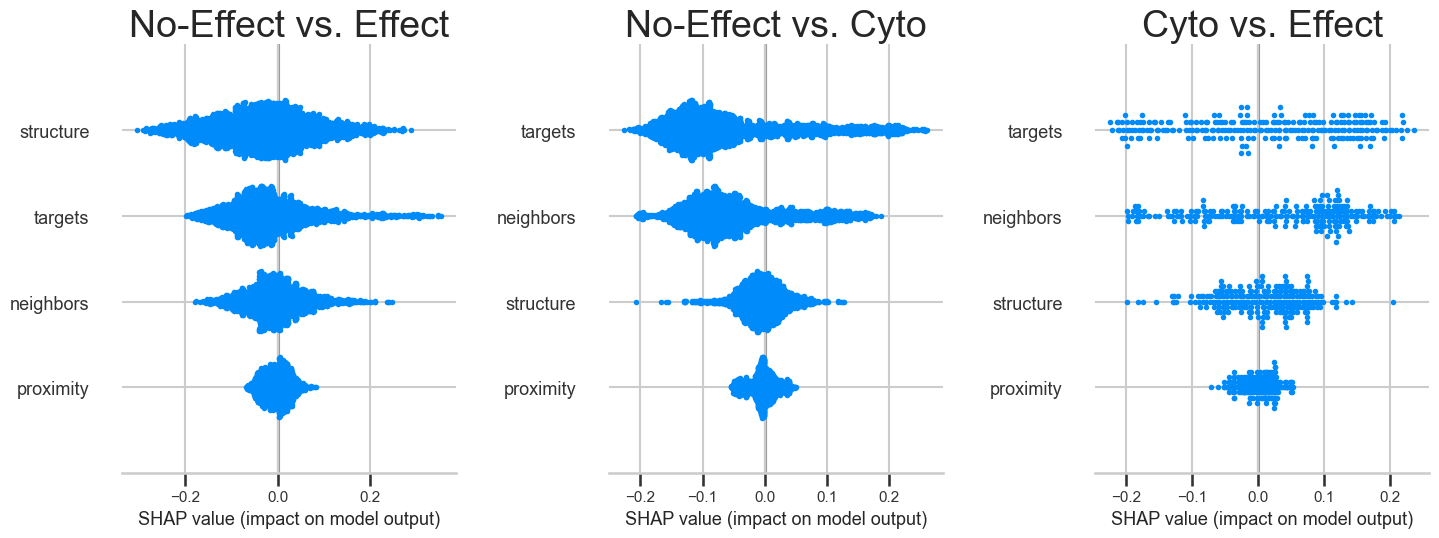

In [6]:
sns.set("talk", font_scale=1.5)
sns.set_style("whitegrid")
fig, axes = plt.subplots(1, 3, figsize=(15, 6), dpi=100, sharex='col')
i = 0
for key in results.keys():
    print(key)
    labels = key.split(' vs. ')
    model = results[key]['model']
    X_train = results[key]['X_train']
    rf = model['clf']
    imputer = model['imputer']
    scaler = model['scaler']
    X_train = pd.DataFrame(scaler.transform(X_train), index=X_train.index, columns=X_train.columns)
    X_train = pd.DataFrame(imputer.transform(X_train), index=X_train.index, columns=X_train.columns)
    explainer = shap.TreeExplainer(rf)
    groups = {
        'structure': [f for f in X_train if 'target' not in f and 'neighbor' not in f and 'cov' not in f],
        'targets': [f for f in X_train if 'target' in f and 'cov' not in f],
        'neighbors': [f for f in X_train if 'neighbor' in f and 'cov' not in f],
        'proximity': [f for f in X_train if 'cov' in f]
    }
    shap_values = explainer.shap_values(X_train)
    shap_group = grouped_shap(shap_values[1], X_train.columns.tolist(), groups)

    plt.sca(axes[i])
    axes[i].set(title=f'{labels[0]} vs. {labels[1]}')
    shap.summary_plot(shap_group.values, features=shap_group.columns, show=False, max_display=15, plot_size=None)
    plt.tight_layout()

    #groups = {
    #    'min': [f for f in X_train if f.endswith('min')],
    #    'max': [f for f in X_train if f.endswith('max')],
    #    'mean': [f for f in X_train if f.endswith('mean')],
    #    'median': [f for f in X_train if f.endswith('median')]
    #}

    #shap_group = grouped_shap(shap_values[1], X_train.columns.tolist(), groups)

    #plt.sca(axes[1, i])
    #shap.summary_plot(shap_group.values, features=shap_group.columns, show=False, max_display=15, plot_size=None)
    #plt.tight_layout()

    i += 1

fig.savefig('shap_broad.png', format="png", dpi=300)
fig.savefig('shap_broad.eps', format="eps", dpi=300)
fig.savefig('shap_broad.pdf', format="pdf", dpi=300)
fig.savefig('shap_broad.svg', format="svg", dpi=300)